In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px

In [2]:
data_file = "../data/raw/train_values.csv"
labels_file = "../data/raw/train_labels.csv"

In [3]:
#Collecting Data

df1 = pd.read_csv(data_file)
df2 = pd.read_csv(labels_file)

In [4]:
df1.shape

(260601, 39)

In [5]:
df2.shape

(260601, 2)

## 3. Data Cleaning

* Remove irrelevant observations (observations need to be specific to the problem you are solving)
* Address missing values (e.g. Imputation techniques, drop features/observations)
* Reformat data types (e.g. boolean, numeric, Datetime)
* Filter unwanted outliers (if you have a legitimate reason)
* Reformat strings (e.g. remove white spaces, mislabeled/misspelt categories)
* Validate (does the data make sense? does the data adhere to the defined business rules? )

In [6]:
#checks whether feature and target dataset contains any NaN's in its rows or columns

df1.isnull().any().any() & df2.isnull().any().any()

False

In [7]:
#merges feature and target dataset

df=pd.merge(df1, df2, on='building_id', how='inner')

In [8]:
df.shape

(260601, 40)

In [9]:
# Variance threshold based feature removals - removes all low-variance features.

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encode_cols = df.select_dtypes(exclude=np.number).columns.tolist()
for col in encode_cols:
    df[col] = encoder.fit_transform(df[col])

threshold_n = 0.95
vt = VarianceThreshold(threshold=(threshold_n*(1 - threshold_n)))
vt.fit(df)
df = df[df.columns[vt.get_support(indices=True)]]

In [10]:
#drop columns that are not necessary for predictions

columns_to_drop = ['building_id']
df = df.drop(columns_to_drop, axis=1)
#df = df[df.columns.drop(list(df.filter(regex='^has_')))]

In [11]:
#assigning feature and target values

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(208480, 24)
(208480,)
(52121, 24)
(52121,)


(None, None)

<AxesSubplot:>

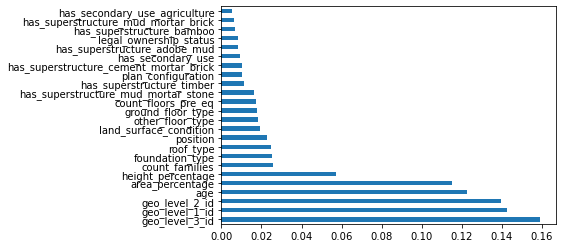

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')

In [14]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.6646888963412937

In [15]:
import category_encoders as ce
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [16]:
#encoding
#instantiate the encoders

one_hot = ce.OneHotEncoder(cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type',
'other_floor_type','position','plan_configuration','legal_ownership_status'])

In [17]:
#build a pipeline for gradient boosting

lgbc = lgb.LGBMClassifier(learning_rate=0.1,n_estimators=1000,max_depth=5,num_leaves=50,n_jobs=-1)

#build a pipeline
pipe_gb = Pipeline([('one_hot', one_hot),
                   ('gradient_boosting',lgbc)])

In [ ]:
#fit the model
pipe_gb.fit(X_train,y_train)

preds_gb = pipe_gb.predict(X_test)

#test the model
f1_score(y_test,preds_gb,average='macro')

/Users/madhuri/opt/anaconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
